<a href="https://colab.research.google.com/github/Vaelastraszz/neural_recommender/blob/master/Neural_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


<h2> Merge movies and ratings </h2>

In [0]:
rating = pd.read_csv("/content/gdrive/My Drive/Movies/ratings.csv")

In [0]:
movies = pd.read_csv("/content/gdrive/My Drive/Movies/movies.csv")

In [0]:
rating = pd.merge(movies, rating, on='movieId')

In [0]:
rating.head(10)

,movieId,title,genres,userId,rating,timestamp
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,944919407
1,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,858275452
2,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,833981871
3,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,943497887
4,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,1230858821
5,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,4.0,859063718
6,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,4.0,849082891
7,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14,4.5,1225311239
8,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,16,3.0,990969772
9,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,5.0,855176628


In [0]:
len(rating.userId.unique()), len(rating.movieId.unique())

(138493, 26744)

<h2> Modification des Ids (movie + user) </h2>

In [0]:
rating.movieId = rating.movieId.astype('category').cat.codes.values

<h2> Split dataset traing testing </h2>

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(rating[:250000], test_size=0.2)

<h2> Mise en place du modèle </h2>

In [0]:
import keras
n_latent_factors_user = 8
n_latent_factors_movie = 10
n_latent_factors_mf = 3
n_users, n_movies = len(rating.userId.unique()), len(rating.movieId.unique())

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
movie_vec_mlp = keras.layers.Dropout(0.05)(movie_vec_mlp)

movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='Movie-Embedding-MF')(movie_input)
movie_vec_mf = keras.layers.Flatten(name='FlattenMovies-MF')(movie_embedding_mf)
movie_vec_mf = keras.layers.Dropout(0.05)(movie_vec_mf)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)


concat = keras.layers.Concatenate()([movie_vec_mlp, user_vec_mlp])
concat_dropout = keras.layers.Dropout(0.15)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat_dropout)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
dropout_1 = keras.layers.Dropout(0.15,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)


dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

pred_mf = keras.layers.dot([movie_vec_mf,user_vec_mf], axes=1, normalize=False)


pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

combine_mlp_mf = keras.layers.Concatenate()([pred_mf, pred_mlp])
result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(50,name='FullyConnected-4')(result_combine)


result = keras.layers.Dense(1,name='Prediction')(deep_combine)


model = keras.Model([user_input, movie_input], result)
opt = keras.optimizers.Adam(lr = 0.001)
model.compile(optimizer=opt,loss= 'mean_absolute_error')

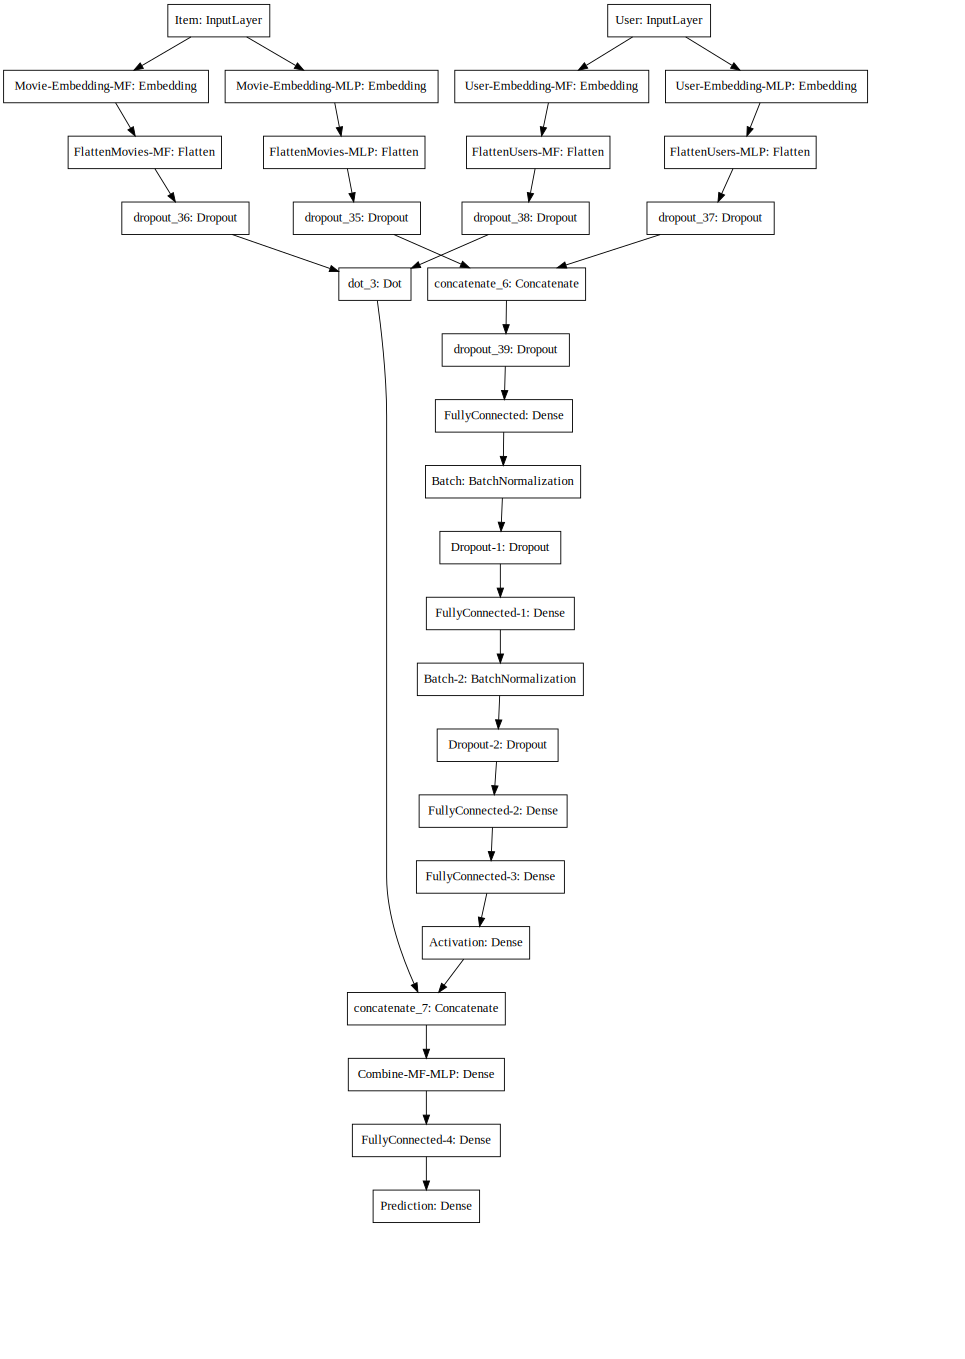

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB',dpi=65).create(prog='dot', format='svg'))

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
STAMP = "{}_recommender_movie".format(datetime.date.today().strftime("%Y-%m-%d"))
 
bst_model_path = "/content/gdrive/My Drive/Movies/{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
save_best_only=True,
save_weights_only=False,
verbose=1)

In [0]:
history = model.fit([train.userId, train.movieId], 
                    train.rating, 
                    epochs=10,
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint],
                    validation_split=0.1)

Train on 180000 samples, validate on 20000 samples
Epoch 1/10
180000/180000 [==============================] - 138s 766us/step - loss: 0.7409 - val_loss: 0.7138

Epoch 00001: val_loss did not improve from 0.69446
Epoch 2/10
180000/180000 [==============================] - 122s 678us/step - loss: 0.6781 - val_loss: 0.7339

Epoch 00002: val_loss did not improve from 0.69446
Epoch 3/10
180000/180000 [==============================] - 126s 698us/step - loss: 0.6020 - val_loss: 0.7392

Epoch 00003: val_loss did not improve from 0.69446
Epoch 4/10
180000/180000 [==============================] - 125s 696us/step - loss: 0.5459 - val_loss: 0.7466

Epoch 00004: val_loss did not improve from 0.69446
Epoch 5/10
180000/180000 [==============================] - 126s 698us/step - loss: 0.5079 - val_loss: 0.7584

Epoch 00005: val_loss did not improve from 0.69446
Epoch 6/10
180000/180000 [==============================] - 125s 696us/step - loss: 0.4833 - val_loss: 0.7642

Epoch 00006: val_loss did no

In [0]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(test.rating, model.predict([test.userId, test.movieId])))

0.7462901209032535
